In [1]:
import pandas as pd
import glob
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [28]:

# Function to read data from a file
def read_slow_data(file):
    # Extract liquid crystal phase, fraction, and repetition number from filename
    lc_phase = re.findall(r'(nematic|smectic|isotropic)', file)
    lc_frac = re.findall(r'(0\.\d+)', file)
    rep = re.findall(r'rep\_(\d+)', file)    
    
    df = pd.read_csv(
        file,
        delim_whitespace=True,
        comment="#",
        header=None,
        names=[
            "step",
            "global_step",
            "Upe",
            "Ubond",
            "Angles"
            "Pxx",
            "Pyy",
            "Pzz",
            "Pxy",
            "Pxz",
            "Pyz",
            "Gaussian0",
            "Gaussian1",
            "Gaussian2",
            'MaierSaupe0',
            "LambdaMaierSaupe0",
            "UDBond"
        ],
    )
    # Turns integers in step column into floats
    df['step'] = df['step'].astype(float) - df['step'].min()
    # Make a chi column using step
    if lc_phase == ['isotropic']:
        df['chi'] = df['step'] / df['step'].max()*8.0
    else:
        df['chi'] = df['step'] / df['step'].max()*7.0
    # Normalize the cross interaction column
    df["U_norm2"] = (df["Gaussian1"] - df["Gaussian1"].min())/(df["Gaussian1"].max() - df["Gaussian1"].min()) 
    # Add new columns for liquid crystal phase, fraction, and repetition number
    df['lc_phase'] = [lc_phase] * len(df)
    df['lc_frac'] = [lc_frac] * len(df)
    df['rep'] = [rep] * len(df)
    df.reset_index(drop=True, inplace=True)
    return df[['step', 'chi', 'U_norm2', 'lc_phase', 'lc_frac', 'rep']]

def stretched_exponential(t, tau, beta):
    return  np.exp(-(t / tau) ** beta)

def find_critical_chi(df):
    # Fit a stretched exponential to the U_norm1 data
    popt, pcov = curve_fit(stretched_exponential, df['chi'], df['U_norm2'], p0=[5, 1])
    # Find the critical chi value
    return popt
# Function for finding point where derivative is largest
def find_max_derivative(df):
    # Filter the U_norm2 data to reduce noise using a running average
    df['U_norm2'] = df['U_norm2'].rolling(window=100).mean()
    # Calculate the derivative of U_norm2 with respect to chi
    df['dU_norm2_dchi'] = np.gradient(df['U_norm2'], df['chi'])
    # Keep the data for chi > 0.1

    # Find the chi value where the derivative is most negative
    return df['chi'][df['dU_norm2_dchi'].idxmin()]
    
# Function to recursively search for files within subdirectories
def search_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list

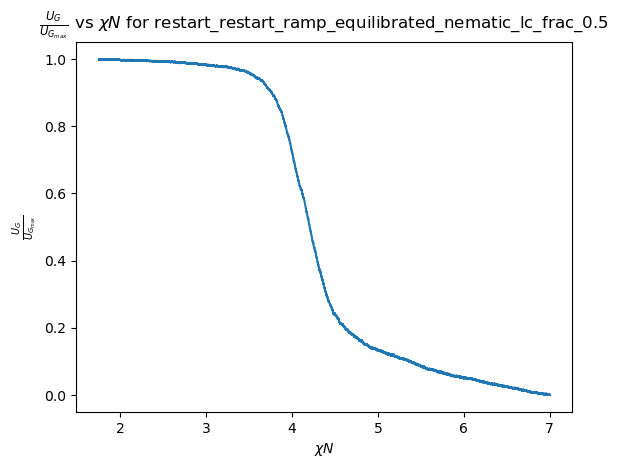

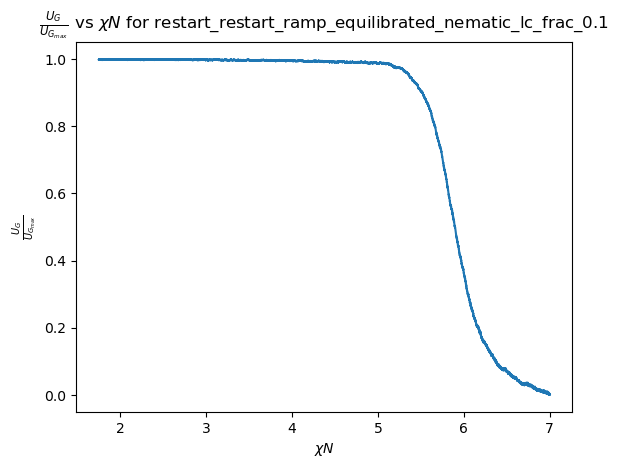

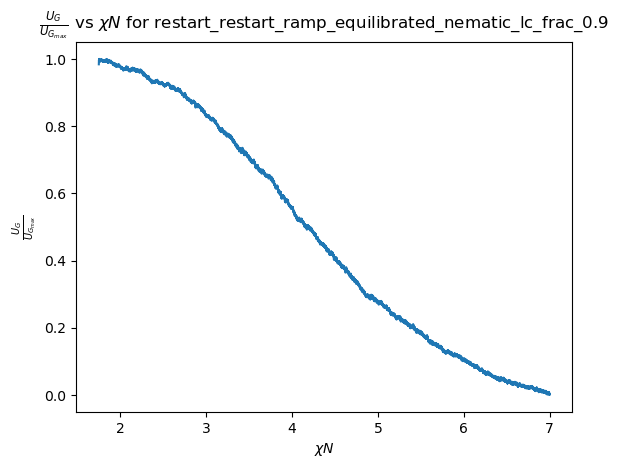

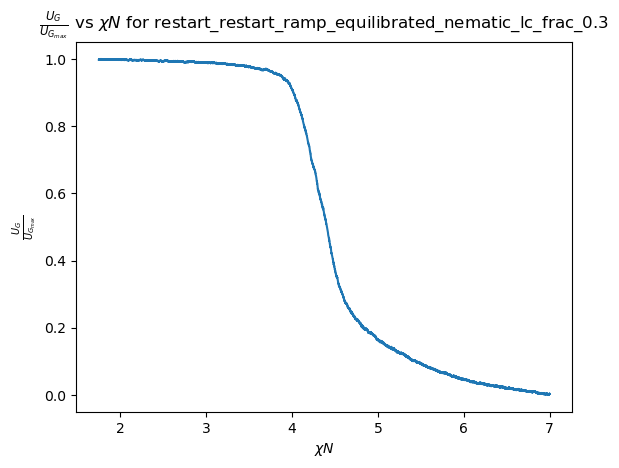

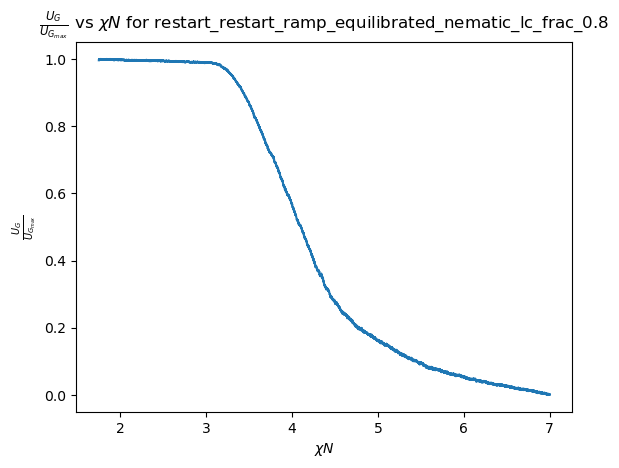

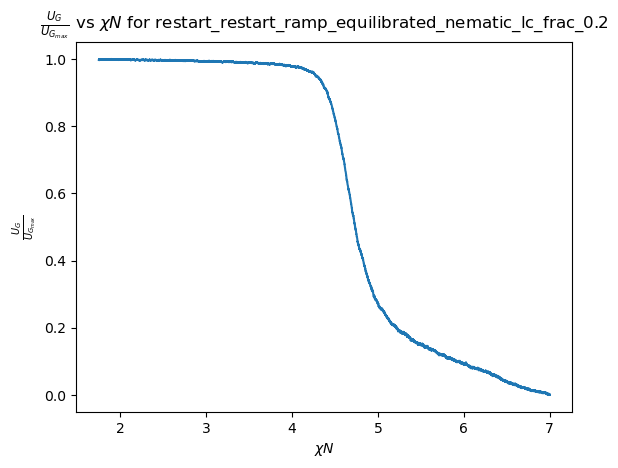

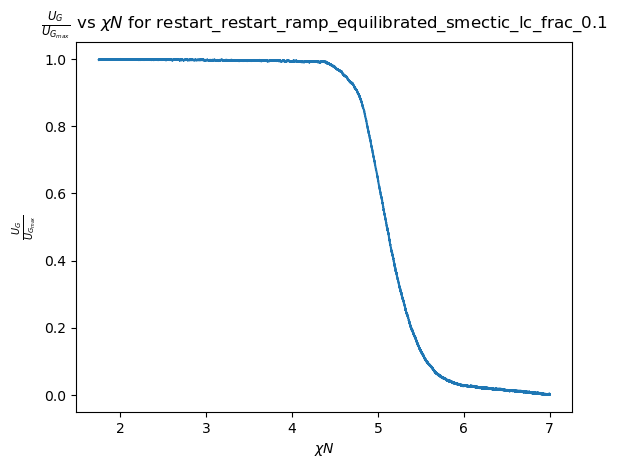

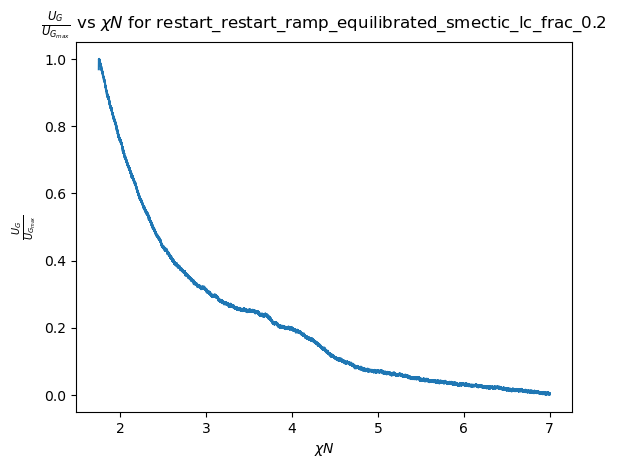

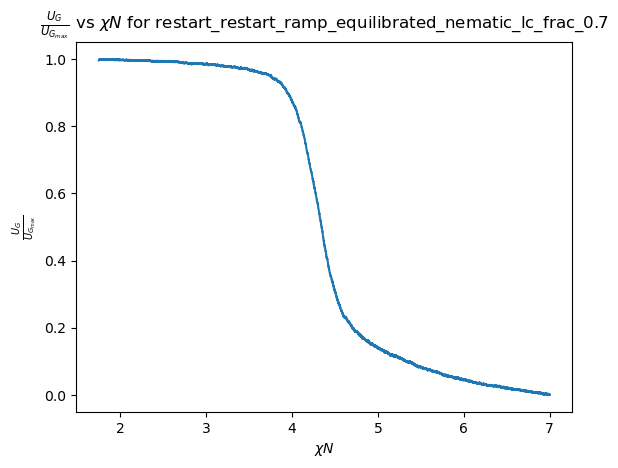

In [6]:
# Read in data from all files
files = search_files("/home/gabriel/Projects/Critical_chi_study/Results/lc_length_6/Results/Log/Very_slow_ramp")

# Plot U_norm2 vs chi for all the first rep of each lc_phase and lc_frac
for file in files:
    filename = os.path.basename(file)
    if "restart_ramp" in filename:
        df = read_slow_data(file)
        # Filter out noise using a gaussian convolution
        
        #df['U_norm2'] = df['U_norm2'].rolling(window=100).mean()
        # Calculate the derivative of U_norm2 with respect to chi
        df['dU_norm2_dchi'] = np.gradient(df['U_norm2'], df['chi'])
        # Keep the data for chi > 0.1
        #df = df[df['chi'] > 0.1]        
        max_d = df['chi'][df['dU_norm2_dchi'].idxmin()]
        

        #Plot the U_norm2 and the gradient data with the critical chi value in two subplotts
        plt.plot(df['chi'], df['U_norm2'])
        plt.xlabel(r'$\chi N$')
        plt.ylabel(r'$\frac{U_{G}}{U_{G_{max}}}$')
        plt.title(r'$\frac{U_{G}}{U_{G_{max}}}$ vs $\chi N$ for ' + filename[:-10])
        plt.show()


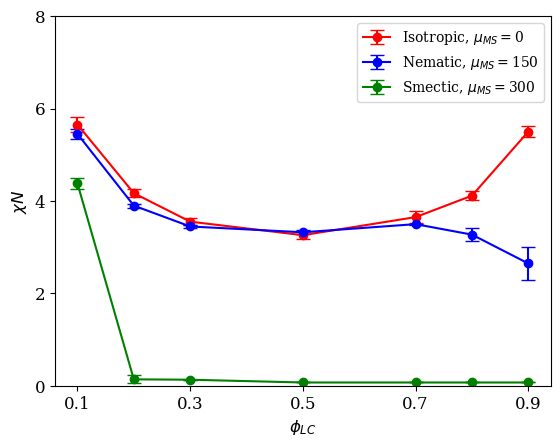

In [40]:
from matplotlib.ticker import MultipleLocator
import matplotlib
matplotlib.rc('font', family='serif')

# Step 1: Create an empty list to store the DataFrames
data = pd.DataFrame()
critical_chis = []
lc_phases = []
lc_fracs = []   
reps = []
targets = []
# Read in data from all files
files = search_files("/home/gabriel/Projects/Critical_chi_study/Results/lc_length_6/Results/Log/Very_slow_ramp")
# Step 2: Loop over your files
for file in files:
    if 'dat' in file:
        slow_df = read_slow_data(file)
        lc_phase = slow_df["lc_phase"][0]
        lc_frac = slow_df["lc_frac"][0]
        rep = slow_df["rep"][0]

        if 'restart_restart' in file:
            targets.append((lc_phase, lc_frac))
            #crit_chi, _ = popt
            crit_chi = find_max_derivative(slow_df)
            critical_chis.append(crit_chi)
            lc_phases.append(lc_phase)
            lc_fracs.append(lc_frac)
            reps.append(rep)
for file in files:
    if 'dat' in file:    
        slow_df = read_slow_data(file)
        lc_phase = slow_df["lc_phase"][0]
        lc_frac = slow_df["lc_frac"][0]
        rep = slow_df["rep"][0]
        if 'very_slow' in file:
            if (lc_phase, lc_frac) not in targets:
                crit_chi = find_max_derivative(slow_df)
                critical_chis.append(crit_chi)
                lc_phases.append(lc_phase)
                lc_fracs.append(lc_frac)
                reps.append(rep)    
            
        
    # Step 3: Read the data into a DataFrame
    # df = read_data(file)
    # popt = find_critical_chi(df)
    # crit_chi, _ = popt
    # critical_chis.append(crit_chi)
    # lc_phases.append(df["lc_phase"][0])
    # lc_fracs.append(df["lc_frac"][0])
    # reps.append(df["rep"][0])
# Add lists to data DataFrame and convert to numpy arrays
data["critical_chi"] = np.array(critical_chis)
data["lc_phase"] = np.array(lc_phases)
data["lc_frac"] = np.array(lc_fracs)
data["rep"] = np.array(reps)
# Group the data by liquid crystal phase and fraction and find the mean critical chi value and its standard deviation
mean_data = data.groupby(["lc_phase", "lc_frac"]).agg(["mean", "std"])

# Separate the data by liquid crystal phase
nematic_data = mean_data.loc["nematic"]
smectic_data = mean_data.loc["smectic"]
isotropic_data = mean_data.loc["isotropic"]
lc_frac = [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9]
#lc_frac = [ 0.2, 0.3, 0.5, 0.7, 0.8, 0.9]

# Plot the data with its standard deviation in circles
plt.errorbar(lc_frac, isotropic_data["critical_chi"]["mean"], yerr=isotropic_data["critical_chi"]["std"], fmt="o-",color="r", label=r"Isotropic, $\mu_{MS}=$0", capsize=5)
plt.errorbar(lc_frac, nematic_data["critical_chi"]["mean"], yerr=nematic_data["critical_chi"]["std"], fmt="o-",color="b" , label=r"Nematic, $\mu_{MS}=$150", capsize=5)
plt.errorbar(lc_frac, smectic_data["critical_chi"]["mean"], yerr=smectic_data["critical_chi"]["std"], fmt="o-",color="g", label=r"Smectic, $\mu_{MS}=$300", capsize=5)
#plt.plot(lc_frac, isotropic_data["critical_chi"]["mean"], marker="o",color="r", linestyle = '-' , label="Isotropic")
#plt.plot(lc_frac, nematic_data["critical_chi"]["mean"], marker="o",color="b" , linestyle = '-',label="Nematic")
#plt.plot(lc_frac, smectic_data["critical_chi"]["mean"], marker="o",color="g", linestyle = '-',label="Smectic")
plt.xlabel(r"$\phi_{LC}$", fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel(r"$\chi N$ ", fontsize=12)
plt.yticks(fontsize=12)
#plt.xlim(0, 1)
plt.ylim(0, 8)
ax = plt.gca()  # Get the current Axes instance on the current figure
# start x axis tics at 0.1
#ax.xaxis.set_major_locator(MultipleLocator(0.2, 0.1))
ax.set_xticks(np.arange(0.1, 1.1, 0.2))  # Set x-axis tick locations starting from 0.1
ax.set_yticks(np.arange(0, 8.1, 2))  # Set x-axis tick locations starting from 0.1
# increase figure dpi



plt.legend()
plt.savefig('/home/gabriel/Projects/Figures/Results/Log/phase_diagram.png', dpi=600, bbox_inches='tight')

plt.show()

